# Hamusic: a pre-processing method of analyzing app-generated music for its graph-based compability with Hamiltonian patterns
Annie Chu, Priscila Morales, Anusha Karandikar, Rajiv Perera

In [173]:
import networkx as nx
import numpy as np

import itertools
from collections import defaultdict

import matplotlib.pyplot as plt
import pandas as pd

Run the cell below each time the notebook is started or restarted to ensure that if you change any code in the library, this notebook will use the latest version of the library code.

In [174]:
%load_ext autoreload
%autoreload 2
%run src/discz_scrape.py
%run src/scrape1.py

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### **Methodology:**

In order to scrape the data collected from the playlist database and convert it into forms that are suitable for data analytics, we coded the first half of Hamusic: ```scrape1.py```. ```scrape1.py``` uses the lightweight python-based Spotify API [Spotipy](https://pypi.org/project/spotipy/) to scrape the data from the database into one large, organized dictionary-containing list assigned to the variable name ```song_data```.

In [175]:
print(song_data)

[{'name': 'right here', 'artist': 'Lil Peep', 'genre': ['emo rap', 'lgbtq+ hip hop'], 'bpm': 110, 'energy': 0.715, 'key': 8, 'danceability': 60, 'loudness': -7}, {'name': 'Baby Blue', 'artist': 'Luke Hemmings', 'genre': ['pop'], 'bpm': 123, 'energy': 0.82, 'key': 0, 'danceability': 54, 'loudness': -3}, {'name': "i'm yours", 'artist': 'Isabel LaRosa', 'genre': ['hyperpop', 'pop'], 'bpm': 111, 'energy': 0.705, 'key': 5, 'danceability': 39, 'loudness': -7}, {'name': 'Lovers Rock', 'artist': 'TV Girl', 'genre': ['indie pop'], 'bpm': 104, 'energy': 0.871, 'key': 5, 'danceability': 55, 'loudness': -5}, {'name': 'Prey', 'artist': 'The Neighbourhood', 'genre': ['modern alternative rock', 'modern rock', 'pop', 'shimmer pop'], 'bpm': 115, 'energy': 0.779, 'key': 9, 'danceability': 51, 'loudness': -5}, {'name': 'Hayloft', 'artist': 'Mother Mother', 'genre': ['indie pop', 'vancouver indie'], 'bpm': 95, 'energy': 0.922, 'key': 9, 'danceability': 52, 'loudness': -2}, {'name': 'Tremors', 'artist': 'B

We must find the adjacency list of the graph in order to find a hamiltonian path from a specific starting node, and all possible hamiltonian paths if the starting node can be any node.

In [176]:
"""
Finds the adjacency list from a graph.

Returns:
    Adjacency list of the graph
"""
def adjList(graph):
    adjList = [[] for _ in range(graph.number_of_nodes())]
    for (src, dest) in graph.edges():
        adjList[src].append(dest)
        adjList[dest].append(src)
    return adjList

"""
Finds all hamiltonian paths from a specific starting vertex with the graph's adjacency list

Returns:
    Nil; changes happen in place
"""
def hampath(graph, v, visited, path, c):
    n = graph.number_of_nodes()
    
    if len(path) == n:
        c.extend(path)
#         print(path)
        return
    
    adj_list = adjList(graph)
    
    for w in adj_list[v]:
        if not visited[w]:
            visited[w] = True
            path.append(w)

            hampath(graph, w, visited, path, c)

            visited[w] = False
            path.pop()
"""
Find all hamiltonian paths from starting from all possible vertices with the graph's adjacency list

Returns:
    All possible hamiltonian paths of the graph
"""
def findallHamPaths(graph):
    n = graph.number_of_nodes()
    allpaths = []
    for startV in range(n):
        path = [startV]
        c = []
        visited = [False] * n
        visited[startV] = True
        
        hampath(graph, startV, visited, path, c)
        final = [c[i * n:(i + 1) * n] for i in range((len(c) + n - 1) // n )]
        allpaths.append(final)
        allpathsflat = [item for sublist in allpaths for item in sublist]
    return allpathsflat

We need to format our scraped Spotify API ```song_data``` into a dictionary data frame in order to easily manipulate the data for our graphs.

In [182]:
i_n = 10
i_list = list(range(i_n))
pd1 = pd.DataFrame(song_data, columns = ['danceability', 'loudness', 'bpm'], index = i_list)

dftest = pd1.to_dict('index')
print(dftest)


{0: {'danceability': 60, 'loudness': -7, 'bpm': 110}, 1: {'danceability': 54, 'loudness': -3, 'bpm': 123}, 2: {'danceability': 39, 'loudness': -7, 'bpm': 111}, 3: {'danceability': 55, 'loudness': -5, 'bpm': 104}, 4: {'danceability': 51, 'loudness': -5, 'bpm': 115}, 5: {'danceability': 52, 'loudness': -2, 'bpm': 95}, 6: {'danceability': 60, 'loudness': -4, 'bpm': 104}, 7: {'danceability': 66, 'loudness': -6, 'bpm': 95}, 8: {'danceability': 70, 'loudness': -4, 'bpm': 94}, 9: {'danceability': 47, 'loudness': -10, 'bpm': 93}}


We need to filter through our graph edges in order to create a sparse, weighted graph that satisfies the thresholds given. In this case, our thresholds are the following: 
1. difference in ```bpm``` <= 3 
2. difference in ```danceability``` <= 5 
3. difference in ```loudness``` <=1 

For every threshold met, we add ```1``` to the edge's ```weight```

In [187]:
pdTEST = pd1.copy()

def createEdges(dfRawData):
    """
    Creates all of the edges in the graph
    
    Returns:
        An indexed data frame of the edges
    """
    allEdgesdf = pd.DataFrame(
        data=list(itertools.combinations(dfRawData.index.tolist(), 2)), 
        columns=['Src', 'Dst'])
    return allEdgesdf

def calcEdges(dfEdges, dfRawData):
    """
    Calculates the difference of three parameters: bpm, danceability, loudness
    in order to filter edges and add appropriate weights
    
    Returns:
        Data frame of all of the weighted edges with their respective parameter
        differences
    """
    calc_dfEdges = dfEdges.copy()
    for i, row in dfEdges.iterrows():
        w = 0
        start = row['Src']
        end = row['Dst']
        dBPM = np.abs(dfRawData.iloc[start]['bpm']-dfRawData.iloc[end]['bpm'])
        dDance = np.abs(dfRawData.iloc[start]['danceability']-dfRawData.iloc[end]['danceability'])
        dLoudness = np.abs(dfRawData.iloc[start]['loudness']-(dfRawData.iloc[end]['loudness']))
        calc_dfEdges.at[i,'dBPM'] = dBPM
        calc_dfEdges.at[i,'dDance'] = dDance
        calc_dfEdges.at[i,'dLoudness'] = dLoudness
        
        if dBPM <= 3:
            w+=1
        if dDance <=5:
            w+=1
        if dLoudness <=1:
            w+=1
        calc_dfEdges.at[i,'weight'] = w
        relevantEdges = calc_dfEdges[calc_dfEdges['weight']>0]
    return relevantEdges

# create weighted graph using our restructured scraped data
ex_dfEdges = createEdges(pdTEST)
calcEdges(ex_dfEdges, pdTEST)

,Src,Dst,dBPM,dDance,dLoudness,weight
1,0,2,1.0,21.0,0.0,2.0
2,0,3,6.0,5.0,2.0,1.0
5,0,6,6.0,0.0,3.0,1.0
6,0,7,15.0,6.0,1.0,1.0
10,1,3,19.0,1.0,2.0,1.0
11,1,4,8.0,3.0,2.0,1.0
12,1,5,28.0,2.0,1.0,2.0
13,1,6,19.0,6.0,1.0,1.0
15,1,8,29.0,16.0,1.0,1.0
21,2,7,16.0,27.0,1.0,1.0


With the data frame of our weighted edges and parameter differences, we can simply create a graph connecting all of the relevant edges by using the visual library ```NetworkX```.

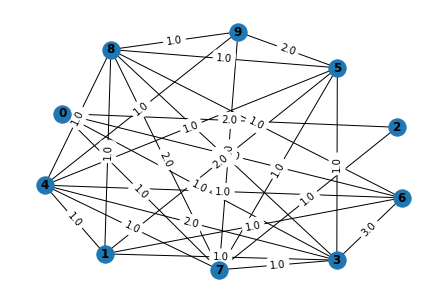

In [180]:
dfGraph = calcEdges(ex_dfEdges, pdTEST)

GG = nx.from_pandas_edgelist(dfGraph, 'Src', 'Dst', ['weight'])

pos = nx.spring_layout(GG, k = 25)
nx.draw(GG, pos, with_labels=True, font_weight='bold')
weight_labels = nx.get_edge_attributes(GG,'weight')
nx.draw_networkx_edge_labels(GG,pos,edge_labels=weight_labels)
plt.show()

Now that our filtered edge weighted graph is complete, we can find the path with the highest ```weight```.

In [181]:
GGallpaths = findallHamPaths(GG)

def getWeight(graph, allpaths):
    """
    Acquire the weight of all the edges in a weighted graph
    
    Returns:
        Nil; changes happen in place"""
    for p in allpaths:
        totalCost = 0
        for i in range(0,len(p)-1):
            edgeCost = graph[p[i]][p[i+1]]['weight']
            totalCost +=edgeCost       
        print(p, totalCost)
    

#show all paths and final score, higher is better
getWeight(GG, GGallpaths)

[0, 2, 7, 3, 1, 6, 4, 5, 8, 9] 10.0
[0, 2, 7, 3, 1, 6, 4, 5, 9, 8] 11.0
[0, 2, 7, 3, 1, 6, 4, 8, 5, 9] 11.0
[0, 2, 7, 3, 1, 6, 4, 8, 9, 5] 11.0
[0, 2, 7, 3, 1, 6, 4, 9, 5, 8] 11.0
[0, 2, 7, 3, 1, 6, 4, 9, 8, 5] 10.0
[0, 2, 7, 3, 1, 6, 8, 4, 5, 9] 11.0
[0, 2, 7, 3, 1, 6, 8, 4, 9, 5] 11.0
[0, 2, 7, 3, 1, 6, 8, 5, 4, 9] 10.0
[0, 2, 7, 3, 1, 6, 8, 5, 9, 4] 11.0
[0, 2, 7, 3, 1, 6, 8, 9, 4, 5] 10.0
[0, 2, 7, 3, 1, 6, 8, 9, 5, 4] 11.0
[0, 2, 7, 3, 1, 4, 6, 8, 5, 9] 11.0
[0, 2, 7, 3, 1, 4, 6, 8, 9, 5] 11.0
[0, 2, 7, 3, 1, 4, 5, 9, 8, 6] 11.0
[0, 2, 7, 3, 1, 4, 9, 5, 8, 6] 11.0
[0, 2, 7, 3, 1, 5, 4, 6, 8, 9] 11.0
[0, 2, 7, 3, 1, 5, 4, 9, 8, 6] 11.0
[0, 2, 7, 3, 1, 5, 8, 6, 4, 9] 11.0
[0, 2, 7, 3, 1, 5, 8, 9, 4, 6] 11.0
[0, 2, 7, 3, 1, 5, 9, 4, 6, 8] 12.0
[0, 2, 7, 3, 1, 5, 9, 4, 8, 6] 12.0
[0, 2, 7, 3, 1, 5, 9, 8, 6, 4] 12.0
[0, 2, 7, 3, 1, 5, 9, 8, 4, 6] 12.0
[0, 2, 7, 3, 1, 8, 6, 4, 5, 9] 11.0
[0, 2, 7, 3, 1, 8, 6, 4, 9, 5] 11.0
[0, 2, 7, 3, 1, 8, 5, 9, 4, 6] 11.0
[0, 2, 7, 3, 1, 8, 9, 5, 4, 